In [1]:
import codecs, glob, os
import numpy as np
import pandas as pd
import scipy.io as sio

In [2]:
import random
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

2022-09-30 21:11:56.160451: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_mat = glob.glob('./Data2/train/*.mat')
train_mat.sort()
train_mat = [sio.loadmat(x)['ecgdata'].reshape(1, 12, 5000) for x in train_mat]

test_mat = glob.glob('../Data2/val/*.mat')
test_mat.sort()
test_mat = [sio.loadmat(x)['ecgdata'].reshape(1, 12, 5000) for x in test_mat]

train_df = pd.read_csv('./Data2/trainreference.csv')
train_df['tag'] = train_df['tag'].astype(np.float32)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/public/home/sugon/miniconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


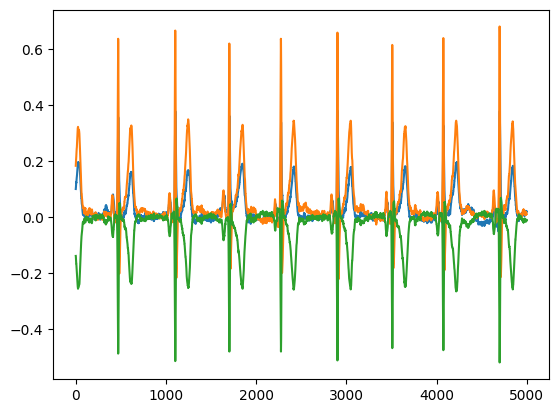

In [4]:

%pylab inline
plt.plot(range(5000), train_mat[0][0][0])
plt.plot(range(5000), train_mat[0][0][1])
plt.plot(range(5000), train_mat[0][0][3])

In [5]:
np.array(train_mat).shape

(1600, 1, 12, 5000)

In [6]:
train_df.shape

(1600, 2)

In [7]:
train_mat[0][0].shape

(12, 5000)

In [8]:
X=[]

In [9]:
for i in range(len(train_mat)):
    X.append(train_mat[i][0].T)

In [10]:
Y=np.array(train_df['tag'],dtype='int')

In [11]:
X_train=np.array(X[:1280])
y_train=np.array(Y[:1280])
X_test=np.array(X[1280:])
y_test=np.array(Y[1280:])

In [12]:
x_train, x_val = X_train[:640], X_train[640:]
y_train, y_val = y_train[:640], y_train[640:]

In [13]:
x_test=X_test
y_test=y_test

In [14]:
# 
def make_pairs(x, y):
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]
    return np.array(pairs), np.array(labels).astype("float32")

In [15]:
# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)
# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)
# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

In [ ]:
print(x_train.shape,x_val.shape,y_train.shape,y_val.shape)
print(pairs_train.shape,labels_train.shape)
print(pairs_test.shape,labels_test.shape)


(640, 5000, 12) (640, 5000, 12) (640,) (640,)
(1280, 2, 5000, 12) (1280,)
(640, 2, 5000, 12) (640,)


In [ ]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (10452, 1000, 12)
x_train_2 = pairs_train[:, 1]

In [ ]:
x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (10452, 1000, 12)
x_val_2 = pairs_val[:, 1]

In [ ]:
x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (2338, 1000, 12)
x_test_2 = pairs_test[:, 1]

In [ ]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """
    求两个向量的欧式距离
    参数：包含两个长度相同的张量
    返回：包含向量欧式距离的张量
        
    """
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

input = layers.Input((5000, 12))



x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv1D(4, 2, activation="relu")(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(16, 2, activation="relu")(x)
x = layers.MaxPooling1D(pool_size= 2)(x)

x = layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(2, activation="relu")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((5000, 12))
input_2 = layers.Input((5000, 12))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)


In [ ]:

def loss(margin=1):
    """为'constrastive_loss'提供一个包含变量'margin'的封闭作用域。
    参数:margin:整数，定义了输入对之间距离的基线应归为异类。-(默认为1)。
    返回'constrastive_loss'函数，附带数据('margin')。
    """
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


In [ ]:
epochs = 10
batch_size = 64
margin = 2  # Margin for constrastive loss.

In [ ]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
# siamese.summary()

In [ ]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 1.2446 - accuracy: 0.4961